## fix file names and remove images without bounding boxes

In [29]:
from PIL import Image
import numpy as np
import os
from tqdm import tqdm

In [13]:
def rename_files_in_directory(directory_path):
    image_dir =  os.path.join(directory_path,'images')
    label_dir = os.path.join(directory_path,'labels')
    for file in tqdm(os.listdir(image_dir)):
        long_name, ext = os.path.splitext(file)
        old_label_name = long_name+'.txt'
        filename = file.split('.')[0]
        image_name = filename+'.jpg'
        label_name = filename+'.txt'
        try:
            os.rename(os.path.join(image_dir, file),os.path.join(image_dir, image_name))
            os.rename(os.path.join(label_dir, old_label_name),os.path.join(label_dir, label_name))
        except:
            print(f'file: {file} fails')
        
ds_directory = "dataset_train/train"
rename_files_in_directory(ds_directory)

100%|██████████████████████████████████████████████████████████████████████████████| 612/612 [00:00<00:00, 1507.02it/s]


In [15]:
def check_empty_files(directory_path):
    empty_files = []
    for filename in tqdm(os.listdir(directory_path)):
        filepath = os.path.join(directory_path, filename)
        if os.path.getsize(filepath) == 0:
            empty_files.append(filepath)
            os.remove(filepath)
            print(f"{filepath} is empty.")
    return empty_files


label_directory = "dataset_train/train/labels"
empty_files = check_empty_files(label_directory)
for file in empty_files:
    filename = os.path.basename(file)
    long_name, ext = os.path.splitext(filename)
    os.remove('dataset_train/train/images/'+long_name+'.jpg')

100%|█████████████████████████████████████████████████████████████████████████████| 612/612 [00:00<00:00, 14570.75it/s]

dataset_train/train/labels\20220119_Chikurachki_10_10_155_50_jpg.txt is empty.
dataset_train/train/labels\20220203_Chikurachki_10_10_155_50_jpg.txt is empty.
dataset_train/train/labels\20220417_Wolf_10_10_-91_0_jpg.txt is empty.
dataset_train/train/labels\20220422_Chikurachki_10_10_155_50_jpg.txt is empty.
dataset_train/train/labels\20220423_Chikurachki_10_10_155_50_jpg.txt is empty.
dataset_train/train/labels\20220429_Chikurachki_10_10_155_50_jpg.txt is empty.
dataset_train/train/labels\20220507_Chikurachki_10_10_155_50_jpg.txt is empty.
dataset_train/train/labels\20220509_Chikurachki_10_10_155_50_jpg.txt is empty.
dataset_train/train/labels\20220510_Chikurachki_10_10_155_50_jpg.txt is empty.
dataset_train/train/labels\20220924_Raung_10_10_114_-8_jpg.txt is empty.
dataset_train/train/labels\20221002_Alaid_10_10_156_51_jpg.txt is empty.
dataset_train/train/labels\20221003_Alaid_10_10_156_51_jpg.txt is empty.
dataset_train/train/labels\20221005_Alaid_10_10_156_51_jpg.txt is empty.
datas

## pad images

In [ ]:
from PIL import Image, ImageDraw

def pad_image_and_adjust_bboxes(image_path, txt_path, target_width=964):
    # Open the image using PIL
    image = Image.open(image_path)
    image_width, image_height = image.size
    if image_width < target_width:
        # Calculate padding on both sides
        left_padding = (target_width - image_width) // 2
        right_padding = target_width - image_width - left_padding
        
        # Create a new white image of target width
        new_image = Image.new("RGB", (target_width, image_height), "white")
        new_image.paste(image, (left_padding, 0))

        # Update bounding boxes
        new_bboxes = []

        with open(txt_path, 'r') as file:
            bboxes = file.readlines()

        for bbox in bboxes:
            class_id, x_center, y_center, width, height = [float(x) for x in bbox.strip().split()]
            x_center_new = (x_center * image_width + left_padding) / target_width
            width_new = width * image_width / target_width

            new_bboxes.append(f"{class_id} {x_center_new} {y_center} {width_new} {height}\n")

        # Save the new image
        new_image.save(image_path)

        # Write updated bounding boxes to txt file
        with open(txt_path, 'w') as file:
            file.writelines(new_bboxes)
        return image_path
    
image_directory = 'dataset_train/train/images'
label_directory = 'dataset_train/train/labels'
padded_imgs = []
for filename in tqdm(os.listdir(image_directory)):
    image_file = os.path.join(image_directory, filename)
    txt_file = os.path.join(label_directory, filename.split('.')[0]+'.txt')
    img_path = pad_image_and_adjust_bboxes(image_file, txt_file)
    if img_path is not None:
        padding_imgs.append(img_path)
        
shapes = []
image_directory = 'dataset_train/train/images'
for filename in os.listdir(image_directory):
    img = Image.open(os.path.join(image_directory, filename))
    shapes.append(list(img.size))
shapes = np.array(shapes)
np.unique(shapes,axis=0)

## split dataset

In [54]:
import os
import shutil
from sklearn.model_selection import train_test_split

def split_dataset(image_dir, label_dir, output_dir, test_size=0.2):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    images = os.listdir(image_dir)
    train_images, test_images = train_test_split(images, test_size=test_size, random_state=42)

    # Directories for the split
    train_img_dir = os.path.join(output_dir, 'train', 'images')
    test_img_dir = os.path.join(output_dir, 'test', 'images')
    train_label_dir = os.path.join(output_dir, 'train', 'labels')
    test_label_dir = os.path.join(output_dir, 'test', 'labels')

    for dir in [train_img_dir, test_img_dir, train_label_dir, test_label_dir]:
        if not os.path.exists(dir):
            os.makedirs(dir)

    for img in train_images:
        shutil.copy(os.path.join(image_dir, img), os.path.join(train_img_dir, img))
        label = img.rsplit('.', 1)[0] + '.txt'  # replace .jpg with .txt
        shutil.copy(os.path.join(label_dir, label), os.path.join(train_label_dir, label))

    for img in test_images:
        shutil.copy(os.path.join(image_dir, img), os.path.join(test_img_dir, img))
        label = img.rsplit('.', 1)[0] + '.txt'
        shutil.copy(os.path.join(label_dir, label), os.path.join(test_label_dir, label))

image_directory = 'dataset_train/train/images'
label_directory = 'dataset_train/train/labels'
output_directory = 'split1'
split_dataset(image_directory, label_directory, output_directory)

In [26]:
shapes = []
image_directory = 'dataset_train/train/images'
for filename in os.listdir(image_directory):
    img = Image.open(os.path.join(image_directory, filename))
    shapes.append(list(img.size))
shapes = np.array(shapes)
np.unique(shapes,axis=0)

In [32]:
np.unique(shapes,axis=0)

array([[612, 964],
       [614, 964],
       [619, 964],
       [636, 964],
       [859, 964],
       [886, 964],
       [939, 964],
       [941, 964],
       [955, 964],
       [961, 964],
       [965, 964]])

## visualize data

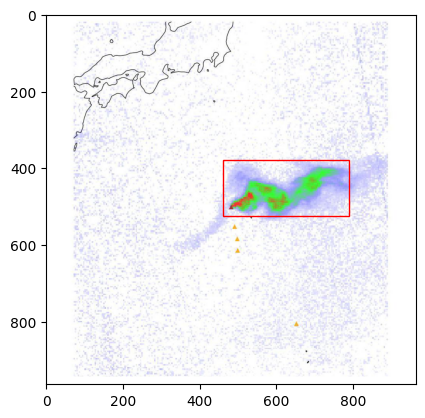

In [51]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
def visualize_bboxes(image_path, txt_path):
    image = Image.open(image_path)
    image_width, image_height = image.size
    with open(txt_path, 'r') as file:
        bboxes = file.readlines()

    fig, ax = plt.subplots(1)
    ax.imshow(image)

    for bbox in bboxes:
        class_id, x_center, y_center, width, height = [float(x) for x in bbox.strip().split()]

        x_center, y_center, width, height = x_center * image_width, y_center * image_height, width * image_width, height * image_height
        xmin, ymin = int(x_center - width/2), int(y_center - height/2)
        rect = patches.Rectangle((xmin, ymin), width, height, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

    plt.show()

image_file = "dataset_train/train/images/20221005_Nishinoshima_10_10_141_27_jpg.jpg"
txt_file = "dataset_train/train/labels/20221005_Nishinoshima_10_10_141_27_jpg.txt"
visualize_bboxes(image_file, txt_file)

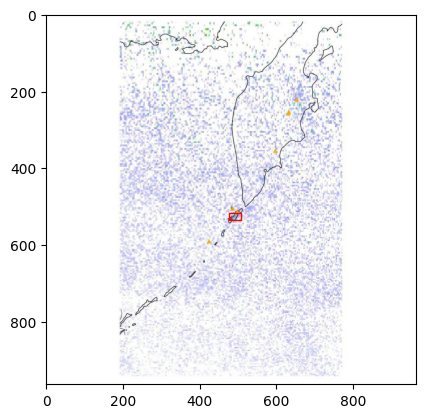

In [41]:
visualize_bboxes(image_file, txt_file)

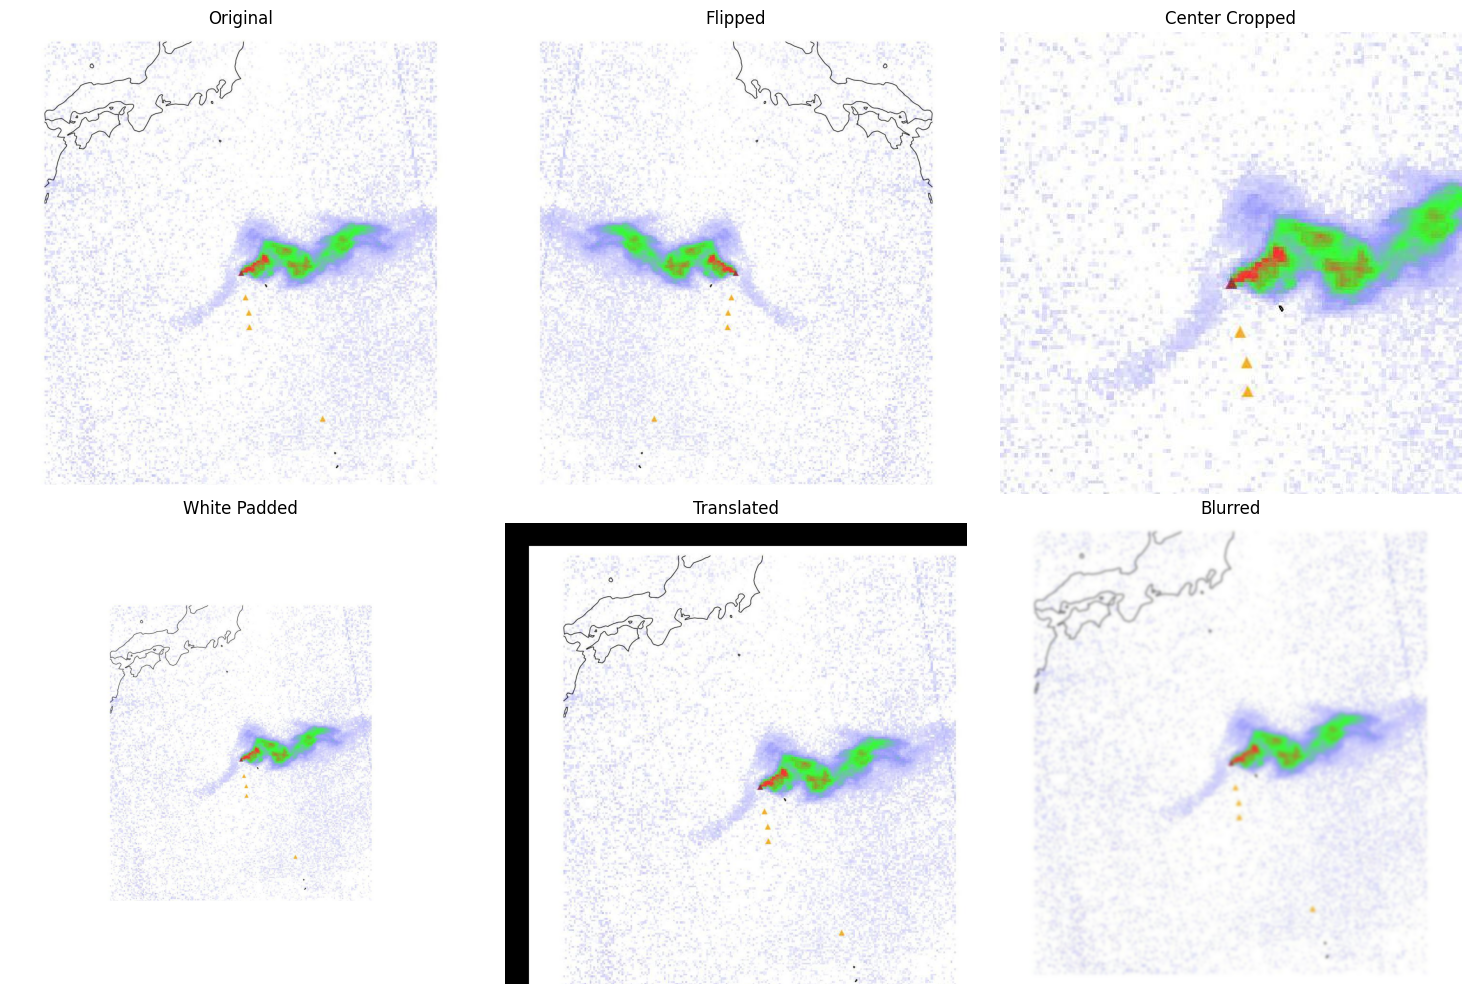

In [11]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Read the image from the given path
image_path = "dataset_train/train/images/20221005_Nishinoshima_10_10_141_27_jpg.jpg"
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB for matplotlib

# Left flip
flipped = cv2.flip(image, 1)

# Center crop
height, width, _ = image.shape
new_height = height // 2
new_width = width // 2
start_row = (height - new_height) // 2
start_col = (width - new_width) // 2
cropped_center = image[start_row:start_row + new_height, start_col:start_col + new_width]

# Image translation
M_translation = np.float32([[1, 0, 50], [0, 1, 50]])
translated = cv2.warpAffine(image, M_translation, (width, height))

# Blurring
blurred = cv2.GaussianBlur(image, (15, 15), 0)

# Create padded image with white padding
height_pad = height // 2
width_pad = width // 2
padded = np.pad(image, ((height_pad//2, height_pad//2), (width_pad//2, width_pad//2), (0, 0)), 'constant', constant_values=255)

# Display using matplotlib
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

axes[0, 0].imshow(image)
axes[0, 0].set_title("Original")
axes[0, 0].axis('off')

axes[0, 1].imshow(flipped)
axes[0, 1].set_title("Flipped")
axes[0, 1].axis('off')

axes[0, 2].imshow(cropped_center)
axes[0, 2].set_title("Center Cropped")
axes[0, 2].axis('off')

# The first subplot of the second row with white padding
axes[1, 0].imshow(padded)
axes[1, 0].set_title("White Padded")
axes[1, 0].axis('off')

axes[1, 1].imshow(translated)
axes[1, 1].set_title("Translated")
axes[1, 1].axis('off')

axes[1, 2].imshow(blurred)
axes[1, 2].set_title("Blurred")
axes[1, 2].axis('off')

plt.tight_layout()
plt.savefig('augmented.jpg')
#plt.show()

(964, 964, 3)


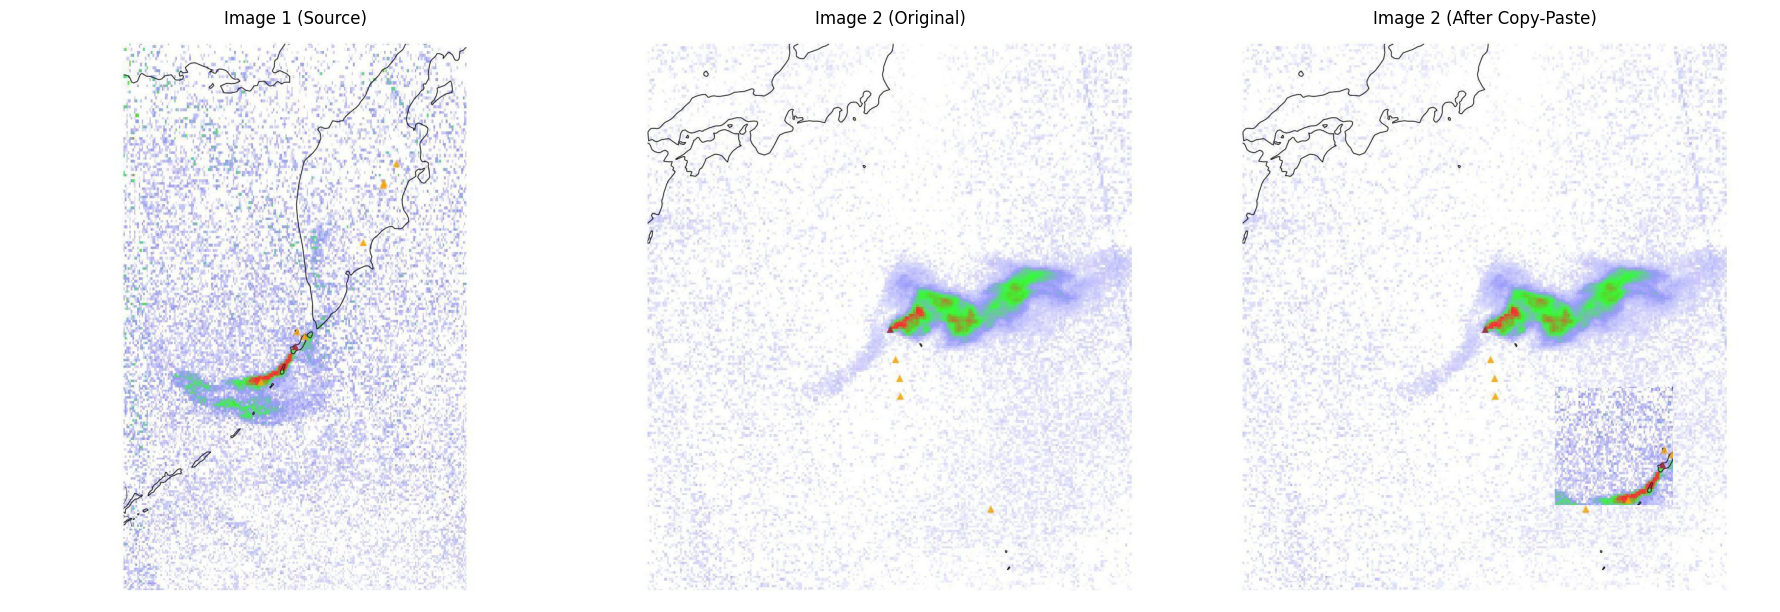

In [24]:
import cv2
import matplotlib.pyplot as plt

# Load the first image
image2_path = "dataset_train/train/images/20221005_Nishinoshima_10_10_141_27_jpg.jpg"
image1_path = "dataset_train/train/images/20220131_Chikurachki_10_10_155_50_jpg.jpg"
image1 = cv2.imread(image1_path)
image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)  # Convert to RGB
print(image1.shape)

# Load the second image

image2 = cv2.imread(image2_path)
image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)  # Convert to RGB

# Copy a region from the first image
x, y, w, h = 300, 400, 200, 200  # Define the x, y position and width, height of the region to copy
copied_region = image1[y:y+h, x:x+w]

# Paste the copied region into the second image at a different location
paste_x, paste_y = 600, 600  # Define the x, y position to paste the region
image2[paste_y:paste_y+h, paste_x:paste_x+w] = copied_region

# Plot the images
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

axes[0].imshow(image1)
axes[0].set_title("Image 1 (Source)")
axes[0].axis('off')

axes[1].imshow(cv2.cvtColor(cv2.imread(image2_path), cv2.COLOR_BGR2RGB))
axes[1].set_title("Image 2 (Original)")
axes[1].axis('off')

axes[2].imshow(image2)
axes[2].set_title("Image 2 (After Copy-Paste)")
axes[2].axis('off')

plt.tight_layout()
#plt.show()
plt.savefig('copy_paste.jpg')

964 964


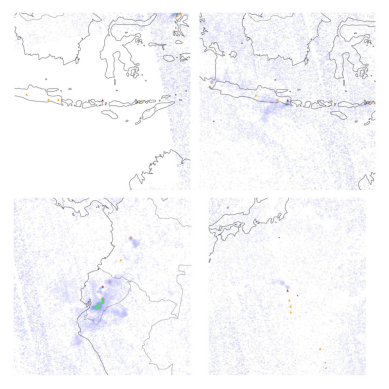

In [35]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def load_image(image_path):
    image = cv2.imread(image_path)
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Load four images
image1 = load_image("dataset_train/train/images/20220215_Sangeang-Api_10_10_119_-8_jpg.jpg")
image2 = load_image("dataset_train/train/images/20221027_Cotopaxi_10_10_-78_-1_jpg.jpg")
image3 = load_image("dataset_train/train/images/20220702_Raung_10_10_114_-8_jpg.jpg")
image4 = load_image("dataset_train/train/images/20221101_Nishinoshima_10_10_141_27_jpg.jpg")

# Assume all images are of the same size for simplicity
height, width, _ = image1.shape
print(height, width)
# Create a blank canvas for the mosaic
mosaic = np.zeros((2 * height, 2 * width, 3), dtype=np.uint8)

# Place each image into one quadrant of the mosaic
mosaic[0:height, 0:width] = image1
mosaic[height:, 0:width] = image2[:height,:width]
mosaic[0:height, width:] = image3
mosaic[height:, width:] = image4

# Plot the images
'''fig, axes = plt.subplots(1, 5, figsize=(20, 4))

axes[0].imshow(image1)
axes[0].set_title("Image 1")
axes[0].axis('off')

axes[1].imshow(image2)
axes[1].set_title("Image 2")
axes[1].axis('off')

axes[2].imshow(image3)
axes[2].set_title("Image 3")
axes[2].axis('off')

axes[3].imshow(image4)
axes[3].set_title("Image 4")
axes[3].axis('off')

axes[4].imshow(mosaic)
axes[4].set_title("Mosaic")
axes[4].axis('off')

plt.tight_layout()'''
plt.imshow(mosaic)
plt.axis('off')
#plt.show()
plt.savefig('mosaic.jpg')

C:\Users\99298\AppData\Local\Temp\ipykernel_13424\3824944201.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['', 'Background', 'Object'])
C:\Users\99298\AppData\Local\Temp\ipykernel_13424\3824944201.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['', 'Background', 'Object'])


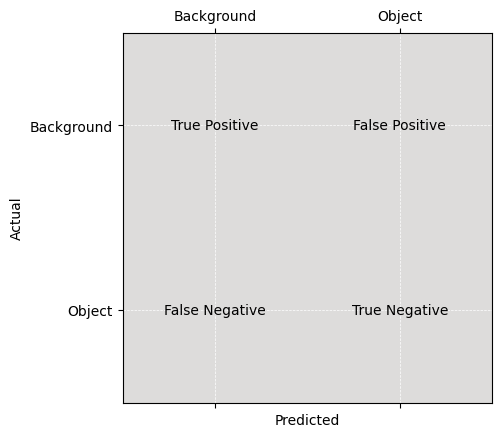

In [41]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots()

# Create a 2x2 matrix filled with zeros for demonstration
conf_matrix = np.zeros((2, 2))

# Create a heatmap with a light blue background
cax = ax.matshow(conf_matrix, cmap='coolwarm', vmin=-1, vmax=1)
ax.set_facecolor('#ADD8E6')  # Setting background to light blue

# Remove colorbar and add gridlines
ax.grid(True, which='both', linestyle='--', linewidth=0.5, color='white')

# Add text annotations
labels = [["True Positive", "False Positive"], ["False Negative", "True Negative"]]
for i in range(2):
    for j in range(2):
        plt.text(j, i, labels[i][j], ha='center', va='center')

# Set axis labels
ax.set_xticklabels(['', 'Background', 'Object'])
ax.set_yticklabels(['', 'Background', 'Object'])

# Set axis titles
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.show()


## cross validation split

In [58]:
filenames = os.listdir('dataset_train/train/images')
groups =  [i.split('_')[1] for i in filenames]
groups

['Wolf',
 'Wolf',
 'Wolf',
 'Wolf',
 'Wolf',
 'Wolf',
 'Wolf',
 'Wolf',
 'Chikurachki',
 'Wolf',
 'Wolf',
 'Wolf',
 'Wolf',
 'Wolf',
 'Chikurachki',
 'Wolf',
 'Wolf',
 'Chikurachki',
 'Wolf',
 'Wolf',
 'Wolf',
 'Wolf',
 'Wolf',
 'Wolf',
 'Wolf',
 'Wolf',
 'Wolf',
 'Wolf',
 'Sangeang-Api',
 'Wolf',
 'Sangeang-Api',
 'Wolf',
 'Sangeang-Api',
 'Wolf',
 'Sangeang-Api',
 'Wolf',
 'Chikurachki',
 'Sangeang-Api',
 'Sangeang-Api',
 'Sangeang-Api',
 'Wolf',
 'Sangeang-Api',
 'Chikurachki',
 'Sangeang-Api',
 'Sangeang-Api',
 'Wolf',
 'Wolf',
 'Wolf',
 'Wolf',
 'Wolf',
 'Wolf',
 'Wolf',
 'Wolf',
 'Wolf',
 'Chikurachki',
 'Chikurachki',
 'Wolf',
 'Chikurachki',
 'Chikurachki',
 'Chikurachki',
 'Chikurachki',
 'Wolf',
 'Wolf',
 'Chikurachki',
 'Chikurachki',
 'Chikurachki',
 'Chikurachki',
 'Chikurachki',
 'Chikurachki',
 'Chikurachki',
 'Chikurachki',
 'Chikurachki',
 'Chikurachki',
 'Chikurachki',
 'Chikurachki',
 'Chikurachki',
 'Chikurachki',
 'Chikurachki',
 'Chikurachki',
 'Chikurachki',
 'Ch

In [61]:
from collections import Counter
Counter(groups)

Counter({'Wolf': 42,
         'Chikurachki': 74,
         'Sangeang-Api': 10,
         'Raung': 137,
         'Ulawun': 11,
         'Bulusan': 11,
         'Ebeko': 79,
         'Alaid': 30,
         'Nishinoshima': 30,
         'Chirinkotan': 4,
         'Kerinci': 45,
         'Cotopaxi': 71,
         'San-Miguel': 20,
         'Lascar': 29})

In [63]:
import os
import shutil
from sklearn.model_selection import GroupKFold
def split_group_dataset(image_dir, label_dir, output_base_dir, n_splits=5):
    if not os.path.exists(output_base_dir):
        os.makedirs(output_base_dir)

    images = os.listdir(image_dir)
    groups = [i.split('_')[1] for i in images]
    
    gkf = GroupKFold(n_splits=n_splits)
    fold = 1
    
    for train_index, test_index in gkf.split(images, groups=groups):
        output_dir = os.path.join(output_base_dir, f'split{fold}')
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
            
        train_images = [images[i] for i in train_index]
        test_images = [images[i] for i in test_index]
        
        train_img_dir = os.path.join(output_dir, 'train', 'images')
        test_img_dir = os.path.join(output_dir, 'test', 'images')
        train_label_dir = os.path.join(output_dir, 'train', 'labels')
        test_label_dir = os.path.join(output_dir, 'test', 'labels')
        
        for dir in [train_img_dir, test_img_dir, train_label_dir, test_label_dir]:
            if not os.path.exists(dir):
                os.makedirs(dir)
        
        for img in train_images:
            shutil.copy(os.path.join(image_dir, img), os.path.join(train_img_dir, img))
            label = img.rsplit('.', 1)[0] + '.txt'  # replace .jpg with .txt
            shutil.copy(os.path.join(label_dir, label), os.path.join(train_label_dir, label))
        
        for img in test_images:
            shutil.copy(os.path.join(image_dir, img), os.path.join(test_img_dir, img))
            label = img.rsplit('.', 1)[0] + '.txt'
            shutil.copy(os.path.join(label_dir, label), os.path.join(test_label_dir, label))
        
        fold += 1

# Provide your paths and call the function
image_directory = 'dataset_train/train/images'
label_directory = 'dataset_train/train/labels'
output_base_directory = 'split_folders'
split_group_dataset(image_directory, label_directory, output_base_directory)

In [36]:
import os
import shutil
from sklearn.model_selection import KFold
def split_group_dataset(image_dir, label_dir, output_base_dir, n_splits=5):
    if not os.path.exists(output_base_dir):
        os.makedirs(output_base_dir)

    images = os.listdir(image_dir)
    gkf = KFold(n_splits=n_splits)
    fold = 1
    for train_index, test_index in gkf.split(images):
        output_dir = os.path.join(output_base_dir, f'split{fold}')
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
            
        train_images = [images[i] for i in train_index]
        test_images = [images[i] for i in test_index]
        
        train_img_dir = os.path.join(output_dir, 'train', 'images')
        test_img_dir = os.path.join(output_dir, 'test', 'images')
        train_label_dir = os.path.join(output_dir, 'train', 'labels')
        test_label_dir = os.path.join(output_dir, 'test', 'labels')
        
        for dir in [train_img_dir, test_img_dir, train_label_dir, test_label_dir]:
            if not os.path.exists(dir):
                os.makedirs(dir)
        
        for img in train_images:
            shutil.copy(os.path.join(image_dir, img), os.path.join(train_img_dir, img))
            label = img.rsplit('.', 1)[0] + '.txt'  # replace .jpg with .txt
            shutil.copy(os.path.join(label_dir, label), os.path.join(train_label_dir, label))
        
        for img in test_images:
            shutil.copy(os.path.join(image_dir, img), os.path.join(test_img_dir, img))
            label = img.rsplit('.', 1)[0] + '.txt'
            shutil.copy(os.path.join(label_dir, label), os.path.join(test_label_dir, label))
        fold += 1
        
# Provide your paths and call the function
image_directory = 'dataset_train/train/images'
label_directory = 'dataset_train/train/labels'
output_base_directory = 'random_split_folders'
split_group_dataset(image_directory, label_directory, output_base_directory)

In [67]:
import os

folder_path = 'dataset_train/train/labels'  # Replace with the path to your folder

total_lines = 0

for filename in os.listdir(folder_path):
    if filename.endswith('.txt'):
        file_path = os.path.join(folder_path, filename)
        with open(file_path, 'r') as file:
            lines = file.readlines()
            total_lines += len(lines)

print(f'Total lines in all .txt files: {total_lines}')

Total lines in all .txt files: 1184


In [73]:
file_path = 'no.txt'  # Replace with the path to your text file

word_list = []

with open(file_path, 'r') as file:
    for line in file:
        first_word = line.split()[0]
        if first_word !='\\hline':
            word_list.append(first_word)

print(word_list)

['Lascar', 'Ahyi', 'Klyuchevskoy', 'San', 'Cotopaxi', 'Kerinci', 'Chirinkotan', 'Nishinoshima', 'Alaid', 'Kaitoku', 'Ioto', 'Ebeko', 'Mayon', 'Bulusan', 'Ulawun', 'Raung', 'Chikurachki', 'Wolf', 'Taal', 'Kavachi', 'Rincon', 'Krakatau', 'Merapi', 'Merapi', 'San', 'San', 'Lewotolok', 'Lewotolok', 'Karymsky', 'Sangay', 'Kadovar', 'Semeru', 'Semeru', 'Bezymianny', 'Sabancaya', 'Langila', 'Masaya', 'Manam', 'Reventador', 'Ibu', 'Fuego', 'Bagana', 'Sheveluch', 'Dukono', 'Santa']


In [74]:
from collections import Counter
Counter(word_list)

Counter({'Lascar': 1,
         'Ahyi': 1,
         'Klyuchevskoy': 1,
         'San': 3,
         'Cotopaxi': 1,
         'Kerinci': 1,
         'Chirinkotan': 1,
         'Nishinoshima': 1,
         'Alaid': 1,
         'Kaitoku': 1,
         'Ioto': 1,
         'Ebeko': 1,
         'Mayon': 1,
         'Bulusan': 1,
         'Ulawun': 1,
         'Raung': 1,
         'Chikurachki': 1,
         'Wolf': 1,
         'Taal': 1,
         'Kavachi': 1,
         'Rincon': 1,
         'Krakatau': 1,
         'Merapi': 2,
         'Lewotolok': 2,
         'Karymsky': 1,
         'Sangay': 1,
         'Kadovar': 1,
         'Semeru': 2,
         'Bezymianny': 1,
         'Sabancaya': 1,
         'Langila': 1,
         'Masaya': 1,
         'Manam': 1,
         'Reventador': 1,
         'Ibu': 1,
         'Fuego': 1,
         'Bagana': 1,
         'Sheveluch': 1,
         'Dukono': 1,
         'Santa': 1})

In [108]:
dates[0]

'20220116'

In [106]:
dates = []
for file in os.listdir('dataset_train/train/images'):
    dates.append(file.split('_')[0])

In [118]:
line = datetime.strptime('20221112', "%Y%m%d").date()
train = []
test = []
for d in dates:
    d = datetime.strptime(d, "%Y%m%d").date()
    if d>line:
        test.append(d)
    else:
        train.append(d)
len(train),len(test)

(476, 117)

In [120]:
images = os.listdir('dataset_train/train/images')
train_images = [i for i in images if datetime.strptime(i.split('_')[0],"%Y%m%d").date() <=line  ]
test_images = [i for i in images if datetime.strptime(i.split('_')[0],"%Y%m%d").date() >line  ]

In [121]:
len(train_images),len(test_images)

(476, 117)

In [126]:
def split_date_dataset(image_dir, label_dir, output_dir,line):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    images = os.listdir(image_dir)
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    train_images = [i for i in images if datetime.strptime(i.split('_')[0],"%Y%m%d").date() <=line  ]
    test_images = [i for i in images if datetime.strptime(i.split('_')[0],"%Y%m%d").date() >line  ]
    print(f'train {len(train_images)} images, test {len(test_images)} images')
    train_img_dir = os.path.join(output_dir, 'train', 'images')
    test_img_dir = os.path.join(output_dir, 'test', 'images')
    train_label_dir = os.path.join(output_dir, 'train', 'labels')
    test_label_dir = os.path.join(output_dir, 'test', 'labels')

    for dir in [train_img_dir, test_img_dir, train_label_dir, test_label_dir]:
        if not os.path.exists(dir):
            os.makedirs(dir)

    for img in train_images:
        shutil.copy(os.path.join(image_dir, img), os.path.join(train_img_dir, img))
        label = img.rsplit('.', 1)[0] + '.txt'  # replace .jpg with .txt
        shutil.copy(os.path.join(label_dir, label), os.path.join(train_label_dir, label))

    for img in test_images:
        shutil.copy(os.path.join(image_dir, img), os.path.join(test_img_dir, img))
        label = img.rsplit('.', 1)[0] + '.txt'
        shutil.copy(os.path.join(label_dir, label), os.path.join(test_label_dir, label))
line = datetime.strptime('20221112', "%Y%m%d").date()
split_date_dataset('dataset_train/train/images', 'dataset_train/train/labels', 'date_split',line)

train 476 images, test 117 images


## transform to coco

In [98]:
import os
import json
from PIL import Image
from tqdm import tqdm
def yolo_to_coco(root, output_json_path):
    coco_data = {
        "images": [],
        "annotations": [],
        "categories": []
    }

    image_id = 0
    annotation_id = 0
    for filename in tqdm(os.listdir(os.path.join(root,'images'))):
        image_path = os.path.join(root,'images', filename)
        image = Image.open(image_path)
        width, height = image.size

        image_info = {
            "id": image_id,
            "file_name": filename,
            "width": width,
            "height": height
        }

        coco_data['images'].append(image_info)

        annotation_file = os.path.join(root, 'labels',filename.replace('.jpg', '.txt').replace('.png', '.txt'))
        with open(annotation_file, 'r') as f:
            for line in f.readlines():
                class_id, x_center, y_center, w, h = map(float, line.strip().split())
                x1 = (x_center - w / 2) * width
                y1 = (y_center - h / 2) * height
                w = w * width
                h = h * height
                annotation_info = {
                    "id": annotation_id,
                    "image_id": image_id,
                    "category_id": int(class_id),
                    "bbox": [x1, y1, w, h],
                    "area": w * h,
                    "iscrowd": 0
                }
                coco_data['annotations'].append(annotation_info)
                annotation_id += 1
        image_id += 1

    # Assuming class ids start from 0 and are contiguous
    num_classes = max([ann["category_id"] for ann in coco_data["annotations"]]) + 1
    for i in range(num_classes):
        category_info = {
            "id": i,
            "name": 'plume'  # You can modify this to be more descriptive
        }
        coco_data["categories"].append(category_info)

    # Save JSON
    with open(output_json_path, 'w') as f:
        json.dump(coco_data, f)

In [99]:
for i in range(1,6):
    yolo_to_coco(f'split_folders/split{i}/train/', f'train_coco{i}.json')
    yolo_to_coco(f'split_folders/split{i}/test/', f'test_coco{i}.json')
    

100%|████████████████████████████████████████████████████████████████████████████████| 117/117 [00:01<00:00, 74.90it/s]


In [94]:
with open('test_coco_random1.json', 'r') as f:
        coco = json.load(f)
coco

{'images': [{'id': 0,
   'file_name': '20220116_Wolf_10_10_-91_0_jpg.jpg',
   'width': 965,
   'height': 964},
  {'id': 1,
   'file_name': '20220118_Wolf_10_10_-91_0_jpg.jpg',
   'width': 965,
   'height': 964},
  {'id': 2,
   'file_name': '20220119_Wolf_10_10_-91_0_jpg.jpg',
   'width': 965,
   'height': 964},
  {'id': 3,
   'file_name': '20220120_Wolf_10_10_-91_0_jpg.jpg',
   'width': 965,
   'height': 964},
  {'id': 4,
   'file_name': '20220121_Wolf_10_10_-91_0_jpg.jpg',
   'width': 965,
   'height': 964},
  {'id': 5,
   'file_name': '20220122_Wolf_10_10_-91_0_jpg.jpg',
   'width': 965,
   'height': 964},
  {'id': 6,
   'file_name': '20220123_Wolf_10_10_-91_0_jpg.jpg',
   'width': 965,
   'height': 964},
  {'id': 7,
   'file_name': '20220124_Wolf_10_10_-91_0_jpg.jpg',
   'width': 965,
   'height': 964},
  {'id': 8,
   'file_name': '20220125_Chikurachki_10_10_155_50_jpg.jpg',
   'width': 964,
   'height': 964},
  {'id': 9,
   'file_name': '20220125_Wolf_10_10_-91_0_jpg.jpg',
   'widt

In [96]:
len(coco['images'])

119

In [93]:
coco['categories']

[{'id': 0, 'name': 'plume'}]

## visualize using coco

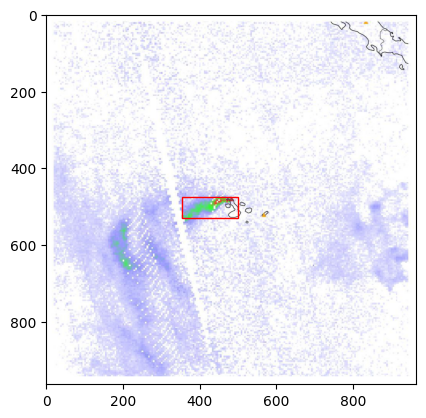

In [78]:
import json
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
def visualize_coco(image_folder, coco_json_path, image_id):
    # Load the COCO annotations
    with open(coco_json_path, 'r') as f:
        coco_data = json.load(f)

    # Find the image info and annotations for the given image_id
    image_info = [img for img in coco_data['images'] if img['id'] == image_id][0]
    annotations = [ann for ann in coco_data['annotations'] if ann['image_id'] == image_id]

    # Open the image file
    image_path = f"{image_folder}/{image_info['file_name']}"
    im = Image.open(image_path)

    # Create figure and axes
    fig, ax = plt.subplots(1)
    ax.imshow(im)

    # Plot each bounding box
    for ann in annotations:
        x, y, width, height = ann['bbox']
        rect = patches.Rectangle((x, y), width, height, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

    plt.show()

# Example usage
visualize_coco("random_split_folders/split1/test/images", "test_coco.json", 0)

In [132]:
# randomly split
TP = (129+214+215+163+171)/5
FP = (37+75+51+59+98)/5
FN = (62+72+58+36+64)/5
TN = (0)/5
TP,FP,FN

(178.4, 64.0, 58.4)

In [128]:
# volcano split
TP = (193+124+115+178+123)/5
FP = (72+60+49+65+48)/5
FN = (159+82+88+100+22)/5
TN = (0)/5
TP,FP,FN

(146.6, 58.8, 90.2)

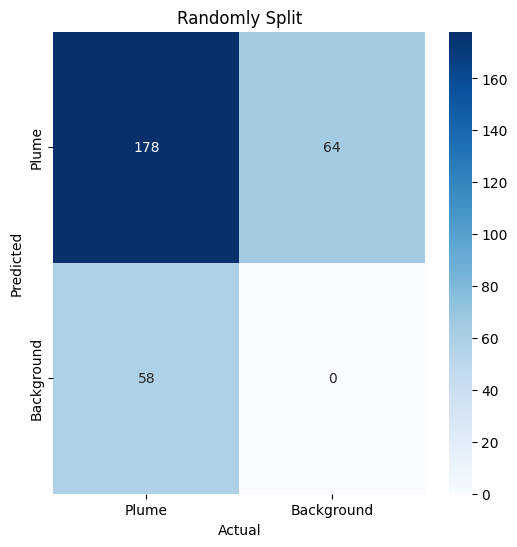

In [137]:
import seaborn as sns
# randomly split
TP = (129+214+215+163+171)/5
FP = (37+75+51+59+98)/5
FN = (62+72+58+36+64)/5
TN = (0)/5
confusion_mat = [[int(TP), int(FP)], [int(FN), 0]]

# Plot the confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(confusion_mat, annot=True, cmap="Blues", fmt="d",
            xticklabels=["Plume", "Background"],
            yticklabels=["Plume", "Background"])
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Randomly Split")
plt.savefig('random_confusion.jpg')
plt.show()

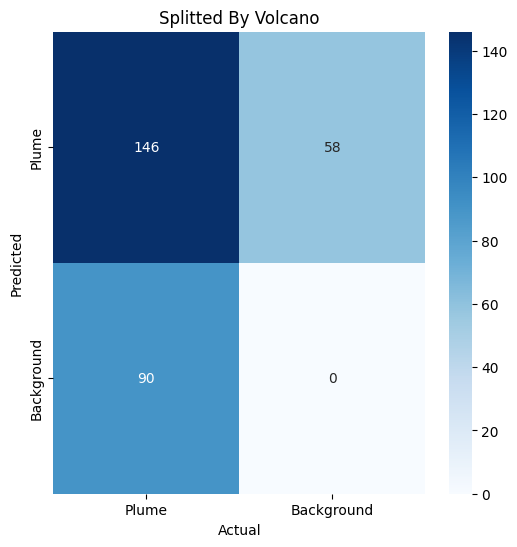

In [140]:
import seaborn as sns
# randomly split
TP = (193+124+115+178+123)/5
FP = (72+60+49+65+48)/5
FN = (159+82+88+100+22)/5
TN = (0)/5
confusion_mat = [[int(TP), int(FP)], [int(FN), 0]]

# Plot the confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(confusion_mat, annot=True, cmap="Blues", fmt="d",
            xticklabels=["Plume", "Background"],
            yticklabels=["Plume", "Background"])
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Splitted By Volcano")
plt.savefig('volcano_confusion.jpg')
plt.show()

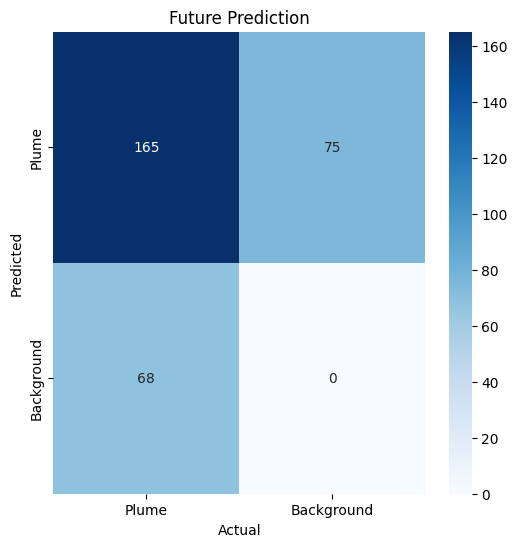

In [142]:
import seaborn as sns
# randomly split
TP = 165
FP = 75
FN = 68
TN = (0)/5
confusion_mat = [[int(TP), int(FP)], [int(FN), 0]]

# Plot the confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(confusion_mat, annot=True, cmap="Blues", fmt="d",
            xticklabels=["Plume", "Background"],
            yticklabels=["Plume", "Background"])
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Future Prediction")
plt.savefig('time_confusion.jpg')
plt.show()